# Prepare the data

In [83]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
import os

# Read in the dataset
trans_df = pd.read_csv(os.path.join("..", "data", "Final for clustering.csv"))

In [84]:
trans_df.columns

Index(['Transaction Date', 'REG_NUM', 'Merchant Name', 'No. of Litres',
       'Transaction Amount', 'VEHICLE MAKE', 'MODEL DERIVATIVE', 'DEPARTMENT',
       'RATE CARD CATEGORY', 'Site', 'District', 'Site Lat', 'Site Long',
       'Merchant Lat', 'Merchant Long', 'Fuel Type',
       'Estimated Price Per Litre', 'Coastal Petrol', 'Inland Petrol',
       'Coastal Diesel', 'Inland Diesel', 'Month Name', 'Weekday Name'],
      dtype='object')

In [85]:
trans_df.shape

(175933, 23)

In [86]:
# Create a new column called fuel price that stores the value from Coastal Petrol if the Fuel Type is Petrol and Coastal Diesel if the Fuel Type is Diesel
trans_df['Fuel Price'] = trans_df.apply(lambda row: row['Coastal Petrol'] if row['Fuel Type'] == 'Petrol' else row['Coastal Diesel'], axis=1)

In [87]:
trans_df[['Fuel Type', 'Fuel Price', 'Coastal Petrol', 'Coastal Diesel']].sample(5)

,Fuel Type,Fuel Price,Coastal Petrol,Coastal Diesel
81365,Petrol,17.5800,17.58,15.0270
171545,Diesel,16.6318,18.89,16.6318
81528,Petrol,17.5800,17.58,15.0270
57847,Diesel,14.0512,16.41,14.0512
141935,Diesel,16.5848,18.82,16.5848


In [88]:
# Remove all transactions with amounts less than 0 or greater than 5000
trans_df = trans_df[(trans_df['Transaction Amount'] >= 0) & (trans_df['Transaction Amount'] <= 5000)]

In [89]:
trans_df.shape

(175925, 24)

In [90]:
# Select the columns for clustering
columns_for_clustering = ['No. of Litres', 'Transaction Amount', 'Fuel Price']

# Keep only the rows without missing values for clustering
data_trans_clustering = trans_df[columns_for_clustering].dropna()

# Encode the categorical variables
data_trans_encoded = pd.get_dummies(data_trans_clustering)

# Identify and replace 'inf' and '-inf' with NaN
data_trans_encoded.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop 'NaN' values, maintaining the index
data_trans_encoded.dropna(inplace=True)

# Prepare data for clustering
X = data_trans_encoded.values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [91]:
X_scaled.shape

(175925, 3)

# k-means clustering

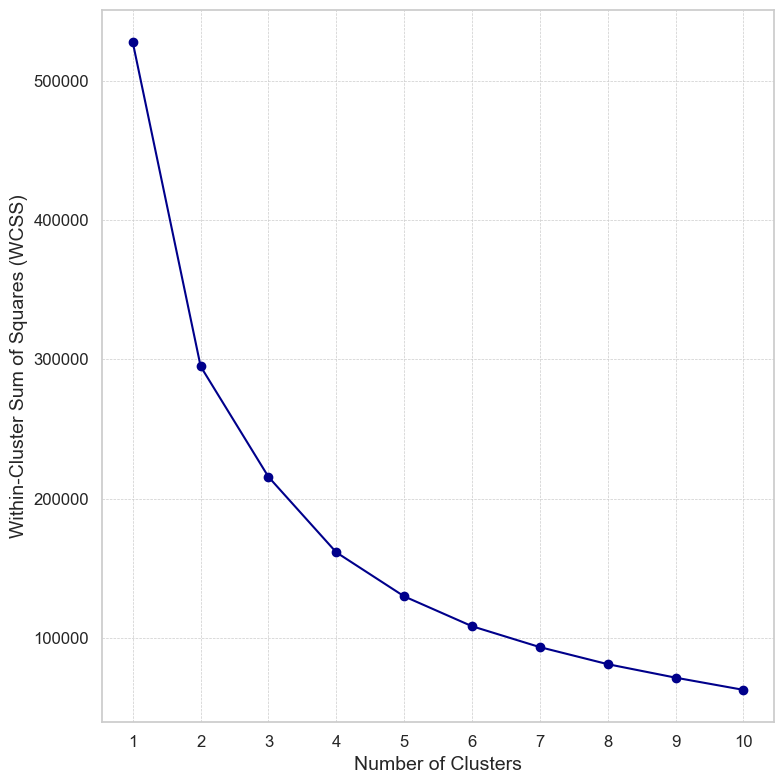

In [68]:
# Calculate WCSS for different numbers of clusters
wcss = []
for i in range(1, 11): # Test 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=1)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Create a professional-looking plot
plt.figure(figsize=(8, 8))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='darkblue')
#plt.title('Elbow Method for Optimal Number of Clusters', fontsize=18, fontweight='bold')
plt.xlabel('Number of Clusters', fontsize=14)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=14)
plt.xticks(range(1, 11), fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Save the plot as a PDF file with high resolution
plt.savefig('../plots/transaction_clustering/kmeans_elbow_method_plot.pdf', format='pdf', dpi=300)

In [92]:
# Apply KMeans clustering
kclusts = 4
kmeans = KMeans(n_clusters=kclusts, init='k-means++', max_iter=300, n_init=10, random_state=1)
kmeans.fit(X_scaled)

# Add the cluster labels to the original dataset
trans_df['kmeans'] = kmeans.labels_

# BIRCH clustering

Silhouette Score for 2 clusters: 0.3265
Silhouette Score for 3 clusters: 0.3242
Silhouette Score for 4 clusters: 0.2629
Silhouette Score for 5 clusters: 0.2549


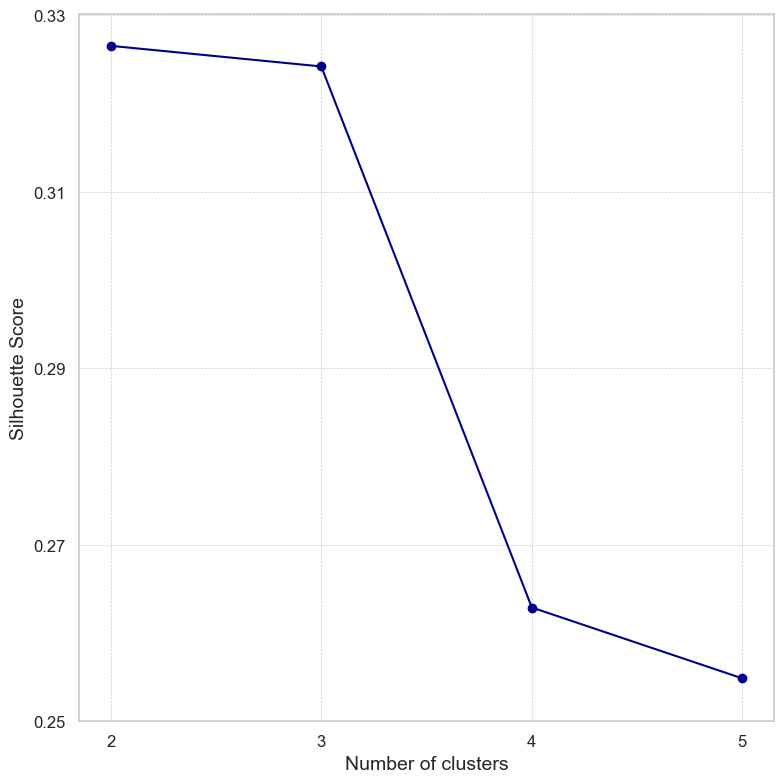

In [71]:
from sklearn.cluster import Birch
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import numpy as np

range_n_clusters = list(range(2, 6))  # Example: evaluating from 2 to 6 clusters
silhouette_scores = []

for n_clusters in range_n_clusters:
    birch = Birch(n_clusters=n_clusters)
    cluster_labels = birch.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Silhouette Score for {n_clusters} clusters: {silhouette_avg:.4f}")

# Plotting silhouette scores with a more professional aesthetic
plt.figure(figsize=(8, 8))
plt.plot(range_n_clusters, silhouette_scores, marker='o', linestyle='-', color='darkblue')
plt.xlabel('Number of clusters', fontsize=14)
plt.ylabel('Silhouette Score', fontsize=14)
plt.xticks(range_n_clusters, fontsize=12)
plt.yticks(np.round(np.linspace(min(silhouette_scores), max(silhouette_scores), 5), 2), fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Save the plot as a PDF file with high resolution
plt.savefig('../plots/transaction_clustering/silhouette_scores_birch.pdf', format='pdf', dpi=300)

plt.show()

In [93]:
from sklearn.cluster import Birch
import matplotlib.pyplot as plt
import numpy as np

# Fit the Birch model
brc = Birch(n_clusters=2)
brc.fit(X_scaled)

Birch(n_clusters=2)

In [94]:
trans_df['BirchCluster'] = brc.labels_

# Gaussian Mixture Model (GMM)

In [95]:
from sklearn.mixture import GaussianMixture

# If X_processed is a sparse matrix, convert it to a dense matrix
if isinstance(X_scaled, np.ndarray):
    X_dense = X_scaled
else:
    X_dense = X_scaled.toarray()

# Apply Gaussian Mixture Model
gmm = GaussianMixture(n_components=kclusts, random_state=1)
gmm_labels = gmm.fit_predict(X_dense)

trans_df['GMMCluster'] = gmm_labels

# Plotting the results

In [108]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FixedLocator, FixedFormatter

def shorten_names(names, max_length=20):
    shortened_names = []
    for name in names:
        if len(name) > max_length:
            shortened_names.append(name[:max_length] + '...')
        else:
            shortened_names.append(name)
    return shortened_names


def four_stacked_plots(data, categorical_vars, cluster_var, titles, filename, max_categories=8, max_length=20, color_theme='tab10', show_proportions=False):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    axs = axs.ravel()

    for i, (cat_var, title) in enumerate(zip(categorical_vars, titles)):
        # Calculate the proportions of each category in each cluster
        cluster_proportions = data.groupby([cluster_var, cat_var]).size().unstack(fill_value=0)
        cluster_proportions = cluster_proportions.div(cluster_proportions.sum(axis=1), axis=0)

        # Get the top categories and group the rest into "Others"
        top_categories = cluster_proportions.sum().nlargest(max_categories).index
        cluster_proportions["Others"] = cluster_proportions.drop(columns=top_categories).sum(axis=1)
        cluster_proportions = cluster_proportions[top_categories.tolist() + ["Others"]]

        # Shorten the category names if necessary
        shortened_names = shorten_names(cluster_proportions.columns, max_length=max_length)

        # Check if the cluster labels start from 0 or -1
        if cluster_proportions.index.min() == 0:
            # Shift the cluster labels up by 1 and rename them
            cluster_proportions.index = [str(i+1) for i in cluster_proportions.index]
        elif cluster_proportions.index.min() == -1:
            # Shift the cluster labels up by 1 (excluding -1) and rename them
            cluster_proportions.index = ["None" if i == -1 else str(i+1) for i in cluster_proportions.index]

        # Get the specified color theme
        color_scheme = plt.cm.get_cmap(color_theme, len(cluster_proportions.columns))
        colors = color_scheme(range(len(cluster_proportions.columns)))

        # Create the stacked bar chart in the corresponding subplot
        cluster_proportions.plot(kind='bar', stacked=True, ax=axs[i], legend=False, color=colors)
        axs[i].set_xticklabels(cluster_proportions.index, rotation=0, fontsize=12)
        axs[i].set_xlabel('Cluster', fontsize=14)
        axs[i].set_ylabel('Proportion', fontsize=14)
        axs[i].set_title(f"{chr(97+i)}) {title}")  # Prepend "a) ", "b) ", "c) ", "d) " to the titles

        if show_proportions:
            # Display the actual proportion numbers on the stacked bar plots if the proportion is greater than 0.1
            for j, rect in enumerate(axs[i].patches):
                height = rect.get_height()
                if height > 0.05:
                    axs[i].text(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2,
                                f"{height:.2f}", ha='center', va='center', fontsize=9, color='black')

        # Create the legend for each subplot
        axs[i].legend(title='Categories', fontsize=10, labels=shortened_names, loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.savefig(filename, format='pdf', bbox_inches='tight', dpi=300)
    plt.close(fig)

def countplot_side_by_side(data1, data2, title1, title2, filename):
    # Filter the data and calculate the sum of counts for the remaining categories
    filtered_data1 = data1.to_frame()
    filtered_data2 = data2.to_frame()
    
    # Shorten the names for each category
    shortened_names1 = filtered_data1.index.astype(str)
    shortened_names2 = filtered_data2.index.astype(str)
    
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
    
    # Set the font size for the labels
    label_font_size = 12
    y_label_font_size = 14
    
    # Plot the data for the first subplot
    ax1.bar(shortened_names1, filtered_data1.iloc[:, 0])
    ax1.set_xticks(range(len(shortened_names1)))
    ax1.set_xticklabels(shortened_names1, fontsize=label_font_size)
    ax1.set_ylabel('Count', fontsize=y_label_font_size)
    ax1.set_xlabel('Cluster', fontsize=y_label_font_size)
    ax1.set_title(f'a) {title1}')
    
    # Plot the data for the second subplot
    ax2.bar(shortened_names2, filtered_data2.iloc[:, 0])
    ax2.set_xticks(range(len(shortened_names2)))
    ax2.set_xticklabels(shortened_names2, fontsize=label_font_size)
    ax2.set_xlabel('Cluster', fontsize=y_label_font_size)
    ax2.set_title(f'b) {title2}')
    
    # Set the y-axis ticks and labels to integer values for both subplots
    yticks1 = ax1.get_yticks().astype(int)
    yticks2 = ax2.get_yticks().astype(int)
    ax1.yaxis.set_major_locator(FixedLocator(yticks1))
    ax1.yaxis.set_major_formatter(FixedFormatter(yticks1))
    ax1.tick_params(axis='y', labelsize=label_font_size)
    ax2.yaxis.set_major_locator(FixedLocator(yticks2))
    ax2.yaxis.set_major_formatter(FixedFormatter(yticks2))
    ax2.tick_params(axis='y', labelsize=label_font_size)
    
    # Adjust the spacing
    plt.tight_layout()
    
    # Save the plot as a PDF file
    plt.savefig(filename, format='pdf', bbox_inches='tight')
    
    # Close the plot
    plt.close(fig)

def countplot_2x2(data1, data2, data3, title1, title2, title3, filename):
    # Filter the data and calculate the sum of counts for the remaining categories
    filtered_data1 = data1.to_frame()
    filtered_data2 = data2.to_frame()
    filtered_data3 = data3.to_frame()

    # Shorten the names for each category
    shortened_names1 = filtered_data1.index.astype(str)
    shortened_names2 = filtered_data2.index.astype(str)
    shortened_names3 = filtered_data3.index.astype(str)

    # Create a figure with three subplots in a 2x2 grid
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))

    # Set the font size for the labels
    label_font_size = 12
    y_label_font_size = 14

    # Plot the data for the first subplot
    ax1.bar(shortened_names1, filtered_data1.iloc[:, 0])
    ax1.set_xticks(range(len(shortened_names1)))
    ax1.set_xticklabels(shortened_names1, fontsize=label_font_size)
    ax1.set_ylabel('Count', fontsize=y_label_font_size)
    ax1.set_xlabel('Cluster', fontsize=y_label_font_size)
    ax1.set_title(f'a) {title1}')

    # Plot the data for the second subplot
    ax2.bar(shortened_names2, filtered_data2.iloc[:, 0])
    ax2.set_xticks(range(len(shortened_names2)))
    ax2.set_xticklabels(shortened_names2, fontsize=label_font_size)
    ax2.set_xlabel('Cluster', fontsize=y_label_font_size)
    ax2.set_title(f'b) {title2}')

    # Plot the data for the third subplot
    ax3.bar(shortened_names3, filtered_data3.iloc[:, 0])
    ax3.set_xticks(range(len(shortened_names3)))
    ax3.set_xticklabels(shortened_names3, fontsize=label_font_size)
    ax3.set_ylabel('Count', fontsize=y_label_font_size)
    ax3.set_xlabel('Cluster', fontsize=y_label_font_size)
    ax3.set_title(f'c) {title3}')

    # Remove the fourth subplot (unused)
    ax4.axis('off')

    # Set the y-axis ticks and labels to integer values for all subplots
    for ax in [ax1, ax2, ax3]:
        yticks = ax.get_yticks().astype(int)
        ax.yaxis.set_major_locator(FixedLocator(yticks))
        ax.yaxis.set_major_formatter(FixedFormatter(yticks))
        ax.tick_params(axis='y', labelsize=label_font_size)

    # Adjust the spacing
    plt.tight_layout()

    # Save the plot as a PDF file
    plt.savefig(filename, format='pdf', bbox_inches='tight')

    # Close the plot
    plt.close(fig)

def boxplot_side_by_side_cont(data, cat_var, cont_var1, cont_var2, title1, title2, filename):
    # Setting the aesthetic style of the plots
    sns.set(style="whitegrid")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

    # Plot the first boxplot
    sns.boxplot(x=cat_var, y=cont_var1, data=data, ax=ax1, palette="cividis")
    ax1.set_ylabel(cont_var1, fontsize=14)
    ax1.set_xlabel('Cluster', fontsize=14)
    ax1.set_title(f'a) {title1}')

    # Plot the second boxplot
    sns.boxplot(x=cat_var, y=cont_var2, data=data, ax=ax2, palette="cividis")
    ax2.set_ylabel(cont_var2, fontsize=14)
    ax2.set_xlabel('Cluster', fontsize=14)
    ax2.set_title(f'b) {title2}')

    # Adjust the spacing
    plt.tight_layout()

    # Save the plot as a PDF file with high resolution
    plt.savefig(filename, format='pdf', dpi=300)

    # Close the plot
    plt.close(fig)

def boxplot_side_by_side_cat(data, cat_var1, cat_var2, cont_var, title1, title2, filename):
    # Setting the aesthetic style of the plots
    sns.set(style="whitegrid")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

    # Plot the first boxplot
    sns.boxplot(x=cat_var1, y=cont_var, data=data, ax=ax1, palette="cividis")
    ax1.set_ylabel(cont_var, fontsize=14)
    ax1.set_xlabel('Cluster', fontsize=14)
    ax1.set_title(f'a) {title1}')

    # Plot the second boxplot
    sns.boxplot(x=cat_var2, y=cont_var, data=data, ax=ax2, palette="cividis")
    ax2.set_ylabel(cont_var, fontsize=14)
    ax2.set_xlabel('Cluster', fontsize=14)
    ax2.set_title(f'b) {title2}')

    # Adjust the spacing
    plt.tight_layout()

    # Save the plot as a PDF file with high resolution
    plt.savefig(filename, format='pdf', dpi=300)

    # Close the plot
    plt.close(fig)

def boxplot_2x2_cat(data, cat_var1, cat_var2, cat_var3, cont_var, title1, title2, title3, filename):
    # Setting the aesthetic style of the plots
    sns.set(style="whitegrid")

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))

    # Plot the first boxplot
    sns.boxplot(x=cat_var1, y=cont_var, data=data, ax=ax1, palette="cividis")
    ax1.set_ylabel(cont_var, fontsize=14)
    ax1.set_xlabel('Cluster', fontsize=14)
    ax1.set_title(f'a) {title1}')

    # Plot the second boxplot
    sns.boxplot(x=cat_var2, y=cont_var, data=data, ax=ax2, palette="cividis")
    ax2.set_ylabel(cont_var, fontsize=14)
    ax2.set_xlabel('Cluster', fontsize=14)
    ax2.set_title(f'b) {title2}')

    # Plot the third boxplot
    sns.boxplot(x=cat_var3, y=cont_var, data=data, ax=ax3, palette="cividis")
    ax3.set_ylabel(cont_var, fontsize=14)
    ax3.set_xlabel('Cluster', fontsize=14)
    ax3.set_title(f'c) {title3}')

    # Remove the fourth subplot (unused)
    ax4.axis('off')

    # Adjust the spacing
    plt.tight_layout()

    # Save the plot as a PDF file with high resolution
    plt.savefig(filename, format='pdf', dpi=300)

    # Close the plot
    plt.close(fig)

def create_proportions_tables(data, categorical_vars, cluster_var, titles, max_categories=8, max_length=20):
    tables = []

    for cat_var, title in zip(categorical_vars, titles):
        # Calculate the proportions of each category in each cluster
        cluster_proportions = data.groupby([cluster_var, cat_var]).size().unstack(fill_value=0)
        cluster_proportions = cluster_proportions.div(cluster_proportions.sum(axis=1), axis=0)

        # Get the top categories and group the rest into "Others"
        top_categories = cluster_proportions.sum().nlargest(max_categories).index
        cluster_proportions["Others"] = cluster_proportions.drop(columns=top_categories).sum(axis=1)
        cluster_proportions = cluster_proportions[top_categories.tolist() + ["Others"]]

        # Shorten the category names if necessary
        shortened_names = shorten_names(cluster_proportions.columns, max_length=max_length)
        cluster_proportions.columns = shortened_names

        # Check if the cluster labels start from 0 or -1
        if cluster_proportions.index.min() == 0:
            # Shift the cluster labels up by 1 and rename them
            cluster_proportions.index = [str(i+1) for i in cluster_proportions.index]
        elif cluster_proportions.index.min() == -1:
            # Shift the cluster labels up by 1 (excluding -1) and rename them
            cluster_proportions.index = ["None" if i == -1 else str(i+1) for i in cluster_proportions.index]

        # Multiply by 100 and round to 2 decimal places
        cluster_proportions = cluster_proportions.round(2)

        # Add the title as a column to the table
        cluster_proportions.insert(0, 'Cluster', cluster_proportions.index)
        cluster_proportions.index = [title] * len(cluster_proportions)

        # Add the table to the list of tables
        tables.append(cluster_proportions)

    return tables


In [97]:
# Add 1 to both cluster labels to start from 1
trans_df['kmeans'] = trans_df['kmeans'] + 1
trans_df['BirchCluster'] = trans_df['BirchCluster'] + 1
trans_df['GMMCluster'] = trans_df['GMMCluster'] + 1

# Convert the 'KmeansCluster' and 'AggCluster' columns to categorical
trans_df['kmeans'] = trans_df['kmeans'].astype('category')
trans_df['BirchCluster'] = trans_df['BirchCluster'].astype('category')
trans_df['GMMCluster'] = trans_df['GMMCluster'].astype('category')

# Set the category .as_ordered()
trans_df['kmeans'] = trans_df['kmeans'].cat.as_ordered()
trans_df['BirchCluster'] = trans_df['BirchCluster'].cat.as_ordered()
trans_df['GMMCluster'] = trans_df['GMMCluster'].cat.as_ordered()

kmeans_clust = trans_df['kmeans'].value_counts()
birch_clust = trans_df['BirchCluster'].value_counts()
gmm_clust = trans_df['GMMCluster'].value_counts()

In [102]:
countplot_2x2(kmeans_clust, birch_clust, gmm_clust, 'k-means', 'BIRCH', 'GMM',
                '../plots/transaction_clustering/cluster_counts_together.pdf')

In [114]:
boxplot_2x2_cat(trans_df, 'kmeans', 'BirchCluster', 'GMMCluster', 'Transaction Amount', 'k-means', 'BIRCH', 'GMM',
                '../plots/transaction_clustering/transaction_amount_boxplots.pdf')

boxplot_2x2_cat(trans_df, 'kmeans', 'BirchCluster', 'GMMCluster', 'No. of Litres', 'k-means', 'BIRCH', 'GMM',
                '../plots/transaction_clustering/litres_boxplots.pdf')

In [109]:
four_stacked_plots(trans_df,
                   ['MODEL DERIVATIVE', 'DEPARTMENT', 'District', 'RATE CARD CATEGORY'],
                   'kmeans',
                   ['Model Derivative', 'Department', 'District', 'Rate Card Category'],
                   '../plots/transaction_clustering/kmeans_clustered_vehicle_plots.pdf',
                   max_categories=5, max_length=15, show_proportions=True)

four_stacked_plots(trans_df,
                   ['MODEL DERIVATIVE', 'DEPARTMENT', 'District', 'RATE CARD CATEGORY'],
                   'BirchCluster',
                   ['Model Derivative', 'Department', 'District', 'Rate Card Category'],
                   '../plots/transaction_clustering/birch_clustered_vehicle_plots.pdf',
                   max_categories=5, max_length=15, show_proportions=True)

four_stacked_plots(trans_df,
                   ['MODEL DERIVATIVE', 'DEPARTMENT', 'District', 'RATE CARD CATEGORY'],
                   'GMMCluster',
                   ['Model Derivative', 'Department', 'District', 'Rate Card Category'],
                   '../plots/transaction_clustering/gmm_clustered_vehicle_plots.pdf',
                   max_categories=5, max_length=15, show_proportions=True)

/var/folders/v7/l0jq1cbd0fnf4ytmwzksxt0r0000gn/T/ipykernel_63296/3946337309.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_scheme = plt.cm.get_cmap(color_theme, len(cluster_proportions.columns))
/var/folders/v7/l0jq1cbd0fnf4ytmwzksxt0r0000gn/T/ipykernel_63296/3946337309.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_scheme = plt.cm.get_cmap(color_theme, len(cluster_proportions.columns))
/var/folders/v7/l0jq1cbd0fnf4ytmwzksxt0r0000gn/T/ipykernel_63296/3946337309.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps

In [111]:
create_proportions_tables(trans_df,
                   ['MODEL DERIVATIVE', 'DEPARTMENT', 'District', 'RATE CARD CATEGORY'],
                   'kmeans',
                   ['Model Derivative', 'Department', 'District', 'Rate Card Category'],
                   max_categories=5, max_length=15)


[                 Cluster  VW POLO VIVO 1....  TOYOTA COROLLA ...  \
 Model Derivative       1                0.00                0.00   
 Model Derivative       2                0.31                0.14   
 Model Derivative       3                0.11                0.16   
 Model Derivative       4                0.01                0.00   
 
                   VW CRAFTER 50 2...  D-MAX 250 HO 4X...  250 D/C HI-RIDE...  \
 Model Derivative                0.10                0.10                0.08   
 Model Derivative                0.03                0.03                0.02   
 Model Derivative                0.07                0.03                0.02   
 Model Derivative                0.07                0.09                0.10   
 
                   Others  
 Model Derivative    0.72  
 Model Derivative    0.47  
 Model Derivative    0.61  
 Model Derivative    0.73  ,
            Cluster  EMERGENCY MEDIC...  HEALTH  TRANSPORT  EDUCATION  \
 Department       1             

In [112]:

create_proportions_tables(trans_df,
                   ['MODEL DERIVATIVE', 'DEPARTMENT', 'District', 'RATE CARD CATEGORY'],
                   'BirchCluster',
                   ['Model Derivative', 'Department', 'District', 'Rate Card Category'],
                   max_categories=5, max_length=15)


[                 Cluster  VW POLO VIVO 1....  250 D/C HI-RIDE...  \
 Model Derivative       1                0.01                0.10   
 Model Derivative       2                0.16                0.04   
 
                   D-MAX 250 HO 4X...  VW CRAFTER 50 2...  TOYOTA COROLLA ...  \
 Model Derivative                0.09                0.07                 0.0   
 Model Derivative                0.05                0.06                 0.1   
 
                   Others  
 Model Derivative    0.73  
 Model Derivative    0.59  ,
            Cluster  EMERGENCY MEDIC...  HEALTH  TRANSPORT  EDUCATION  \
 Department       1                0.44    0.24       0.05       0.07   
 Department       2                0.34    0.23       0.13       0.08   
 
             SOCIAL DEVELOPM...  Others  
 Department                0.06    0.15  
 Department                0.07    0.15  ,
          Cluster  Unknown  OR Tambo  Sarah Baartman  Chris Hani  Joe Gqabi  \
 District       1     0.34      0.

In [113]:

create_proportions_tables(trans_df,
                   ['MODEL DERIVATIVE', 'DEPARTMENT', 'District', 'RATE CARD CATEGORY'],
                   'GMMCluster',
                   ['Model Derivative', 'Department', 'District', 'Rate Card Category'],
                   max_categories=5, max_length=15)

[                 Cluster  VW POLO VIVO 1....  TOYOTA COROLLA ...  \
 Model Derivative       1                0.38                0.22   
 Model Derivative       2                0.00                0.00   
 Model Derivative       3                0.21                0.17   
 Model Derivative       4                0.01                0.01   
 
                   VW CRAFTER 50 2...  D-MAX 250 HO 4X...  250 D/C HI-RIDE...  \
 Model Derivative                0.00                0.00                0.00   
 Model Derivative                0.09                0.09                0.09   
 Model Derivative                0.05                0.01                0.01   
 Model Derivative                0.09                0.08                0.09   
 
                   Others  
 Model Derivative    0.40  
 Model Derivative    0.72  
 Model Derivative    0.55  
 Model Derivative    0.73  ,
            Cluster  EMERGENCY MEDIC...  HEALTH  TRANSPORT  EDUCATION  \
 Department       1             